# import 사항

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


2024-08-21 12:43:00.151798: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 12:43:00.158912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 12:43:00.167102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 12:43:00.169395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 12:43:00.176307: I tensorflow/core/platform/cpu_feature_guar

# UNet 구현
안녕하세요 이번영상도 잘 보고 갑니다:)  U-net 구조 이미지에서는 마지막 output map channel이 2로 되어있는데 왜 1로 바꾸신건지 알 수 있을까요?

 
처음에는 output map channel 을 2개로 한 후, nn.CrossEntropyLoss 를 사용하려고 했는데요. 
이는 output map channel 을 1개로 한 후 nn.BCELoss ( binary cross entropy loss ) 을 사용하는 것과 동일하기 때문에 변경하였습니다. 그리고 일반적으로 본 예제처럼 class 가 2개인 경우는 output map channel 을 1 로 한 후 nn.BCELoss 를 일반적으로 사용합니다 :)

In [2]:
# 하이퍼 파라미터 설정
lr = 1e-3
batch_size = 3
num_epoch = 100

data_dir = "./dataset"
ckpt_dir = "./checkpoint"
log_dir = "./log"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 네트워크 구축
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # cbr2d가 무엇인가 3개의 레이어를 하나의 함수로 묶은것
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            # convolution layer 정의
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            # batch normaliztion layer 정의
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            # relu layer 정의
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            print(cbr)

            return cbr
        
        # contracting path
        # 제일 첫 화살표이고 중심을 기준으로 좌측이 엔코더이므로 enc 1번째의 stage의 첫번쩨 화살표
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)

    # x = 입력 이미지
    def forward(self, x):
        # 인코더 스테이지
        enc1_1 = self.enc1_1(x)
        print(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool1(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool1(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool1(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # 디코더 스테이지
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.concat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.concat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.concat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.concat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# Dataset 구현

In [3]:
from torchvision import transforms, datasets

# transform = transforms.Compose({
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
# })

# 데이터 로더 구현

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transfrom=None):
        self.data_dir = data_dir
        self.transform = transfrom

        lst_data = os.listdir(self.data_dir)

        lst_img = [f for f in lst_data if f.startswith("img")]
        lst_mask = [f for f in lst_data if f.startswith("mask")]

        lst_img.sort()
        lst_mask.sort()

        self.lst_img = lst_img
        self.lst_mask = lst_mask

    def __len__(self):
        return len(self.lst_mask)
    
    def __getitem__(self, index):
        img = np.load(os.path.join(self.data_dir, self.lst_img[index]))
        mask = np.load(os.path.join(self.data_dir, self.lst_mask[index]))

        # normalization
        img = img/255.0
        mask = mask/255.0

        if img.ndim == 2:
            img = img[:, :, np.newaxis]
            
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]
            # 같은 효과니까 나중에 확인해보기
            # lable = torch.unsqueeze(label, dim=-1)

        data = {"img" : img, "mask" : mask}

        if self.transform:
            data = self.transform(data)
        
        return data

In [4]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'))

In [5]:
data = dataset_train.__getitem__(0)

img = data["img"]
mask = data["mask"]

In [6]:
img.shape

(512, 512, 3)

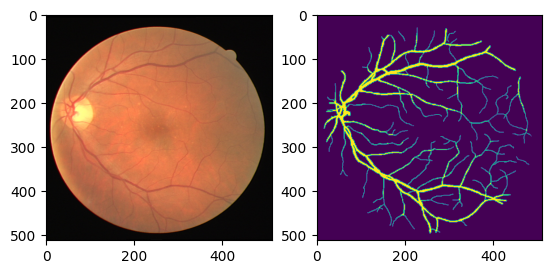

In [7]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(img.squeeze())

plt.subplot(122)
plt.imshow(mask.squeeze())

plt.show()

# trasform 함수 구현

In [8]:
class ToTensor(object):
    def __call__(self, data):
        img, mask = data["img"], data["mask"]
        img = img.transpose((2, 0, 1)).astype(np.float32)
        mask = mask.transpose((2, 0, 1)).astype(np.float32)

        data = {"img" : torch.from_numpy(img), "mask" : torch.from_numpy(mask)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        img, mask = data["img"], data["mask"]

        img = (img - self.mean) / self.std

        data = {"img" : img, "mask" : mask}

        return data
    
class RandomFlip(object):
    def __call__(self, data):
        img, mask = data["img"], data["mask"]

        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)

        if np.random.rand() > 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)

        data = {"img" : img, "mask" : mask}

        return data

class GrayScale(object):
    def __call__(self, data):
        img , mask = data["img"], data["mask"]

        if img.shape[0] != 3:
            raise ValueError("Input tensor must have 3 channels (RGB).")

        # 가중치 적용
        r, g, b = img[0], img[1], img[2]
        grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b

        data = {"img" : grayscale, "mask" : mask}


        # 그레이스케일 이미지를 (1, H, W) 형식으로 변경
        return data

In [9]:
img = data["img"]
mask = data["mask"]
print(img.shape)
print(mask.shape)
print(type(img))

(512, 512, 3)
(512, 512, 1)
<class 'numpy.ndarray'>


In [10]:
transform = transforms.Compose({
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    ToTensor()
})

dataset_train = Dataset(data_dir="./dataset/train/", transfrom=transform)
data = dataset_train.__getitem__(0)

img = data["img"]
mask = data["mask"]

In [11]:
print(img.shape)
print(mask.shape)
print(type(img))

(3, 512, 512)
(1, 512, 512)
<class 'numpy.ndarray'>


In [12]:
# img = img.numpy().transpose((1,2,0))
# print(img.shape)

# plt.subplot(121)
# plt.imshow(img.squeeze())

# plt.subplot(122)
# plt.imshow(mask.squeeze())

# plt.show()

# 네트워크 학습하기

In [13]:
transform = transforms.Compose([
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    ToTensor(),
])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transfrom=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transfrom=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=8)

In [14]:
sample = dataset_train[0]  # 예를 들어, 첫 번째 샘플을 가져옵니다.

# 샘플 확인
img = sample['img']
mask = sample['mask']
print(img.shape)
print(type(img))

torch.Size([3, 512, 512])
<class 'torch.Tensor'>


In [15]:
# DataLoader 객체에서 첫 번째 배치 데이터 확인
for batch in loader_train:
    # 배치 데이터에서 이미지와 마스크 추출
    imgs, masks = batch['img'], batch['mask']
    
    # 데이터 모양 확인
    print(f"Images batch shape: {imgs.shape}")
    print(f"Masks batch shape: {masks.shape}")
    
    # 데이터 샘플 하나 확인 (선택 사항)
    print(f"First image in batch shape: {imgs[0].shape}")
    print(f"First mask in batch shape: {masks[0].shape}")
    
    # 루프를 종료하려면 break를 추가
    break


/home/kunsu/miniconda3/envs/py310/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Images batch shape: torch.Size([3, 3, 512, 512])
Masks batch shape: torch.Size([3, 1, 512, 512])
First image in batch shape: torch.Size([3, 512, 512])
First mask in batch shape: torch.Size([1, 512, 512])


/home/kunsu/miniconda3/envs/py310/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# 네트워크 생성하기

In [16]:
net = UNet().to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3

## 손실함수 정의하기

In [17]:
fn_loss = nn.BCEWithLogitsLoss().to(device)

# optimizer 설정하기

In [18]:
optim = torch.optim.Adam(net.parameters(), lr = lr)

# 기타 variable 설정

In [19]:
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 기타 functions 설정

In [20]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x * std) + mean
fn_class = lambda x : 1.0 * (x > 0.5)

# TensorBoard 사용을 위한 SummaryWriter설정

In [21]:
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 저장하기

In [22]:
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net' : net.state_dict(), 'optim' : optim.state_dict()}, "./%s/model_epoch%d.pth" % (ckpt_dir, epoch))

# 네트워크 불러오기

In [23]:
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# 네트워크 학습 시키기

In [24]:
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net= net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch +1):
    #train
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train, 1):
        #forward pass
        img = data['img'].to(device)
        mask = data['mask'].to(device)

        output = net(img)

        #backward pass
        optim.zero_grad()
        loss = fn_loss(output, mask)
        loss.backward()

        optim.step()

        #손실함수 계한
        loss_arr += [loss.item()]

        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
              (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

        #TensorBoard 저장하기
        img = fn_tonumpy(fn_denorm(img, mean=0.5, std=0.5))
        mask = fn_tonumpy(mask)
        output = fn_tonumpy(fn_class(output))

        writer_train.add_image('img', img, num_batch_train * (epoch -1) + batch, dataformats = 'NHWC')
        writer_train.add_image('mask', mask, num_batch_train * (epoch -1) + batch, dataformats = 'NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch -1) + batch, dataformats = 'NHWC')

    writer_train.add_scalar('loss_arr', np.mean(loss_arr), epoch)

    #validation
    with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(loader_val, 1):
            #forward pass
            img = data['img'].to(device)
            mask = data['mask'].to(device)

            output = net(img)

            #손실함수 계산
            loss = fn_loss(output, mask)

            loss_arr += [loss.item()]

            print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))
            
            #TensorBoard 저장
            img = fn_tonumpy(fn_denorm(img, mean=0.5, std=0.5))
            mask = fn_tonumpy(mask)
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('img', img, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('mask', mask, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

    if epoch // 5 == 0:
        save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

writer_train.close()
writer_val.close()



TRAIN: EPOCH 0001 / 0100 | BATCH 0001 / 0022 | LOSS 0.7311
TRAIN: EPOCH 0001 / 0100 | BATCH 0002 / 0022 | LOSS 0.7126
TRAIN: EPOCH 0001 / 0100 | BATCH 0003 / 0022 | LOSS 0.6897
TRAIN: EPOCH 0001 / 0100 | BATCH 0004 / 0022 | LOSS 0.6643
TRAIN: EPOCH 0001 / 0100 | BATCH 0005 / 0022 | LOSS 0.6412
TRAIN: EPOCH 0001 / 0100 | BATCH 0006 / 0022 | LOSS 0.6228
TRAIN: EPOCH 0001 / 0100 | BATCH 0007 / 0022 | LOSS 0.6042
TRAIN: EPOCH 0001 / 0100 | BATCH 0008 / 0022 | LOSS 0.5863
TRAIN: EPOCH 0001 / 0100 | BATCH 0009 / 0022 | LOSS 0.5717
TRAIN: EPOCH 0001 / 0100 | BATCH 0010 / 0022 | LOSS 0.5583
TRAIN: EPOCH 0001 / 0100 | BATCH 0011 / 0022 | LOSS 0.5481
TRAIN: EPOCH 0001 / 0100 | BATCH 0012 / 0022 | LOSS 0.5385
TRAIN: EPOCH 0001 / 0100 | BATCH 0013 / 0022 | LOSS 0.5286
TRAIN: EPOCH 0001 / 0100 | BATCH 0014 / 0022 | LOSS 0.5192
TRAIN: EPOCH 0001 / 0100 | BATCH 0015 / 0022 | LOSS 0.5110
TRAIN: EPOCH 0001 / 0100 | BATCH 0016 / 0022 | LOSS 0.5038
TRAIN: EPOCH 0001 / 0100 | BATCH 0017 / 0022 | LOSS 0.49

In [3]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
tensorboard --logdir='./log'

Reusing TensorBoard on port 6006 (pid 2317), started 0:00:11 ago. (Use '!kill 2317' to kill it.)

# evaluation